# Random Forest ile Maaş Sınıflandırma
Bu kod "Dataset salary 2024" veri setini kullanarak çalışanların deneyim seviyelerini tahmin etmek için bir Random Forest sınıflandırma modeli oluşturur.

1. Gerekli kütüphanelerin yüklenmesi.
2. Veri setinin yüklenmesi ve ön işleme (nadir görülen iş unvanlarının filtrelenmesi).
3. Kategorik değişkenlerin kodlanması (One-Hot ve Ordinal Encoding).
4. Verinin eğitim ve test setlerine ayrılması.
5. Random Forest modelinin eğitilmesi.
6. Modelin performansının değerlendirilmesi ve görselleştirilmesi.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
                              BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier)
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

## Veri Yükleme ve Filtreleme
Veri setini yüklüyoruz ve 'job titles' sütunundaki az sayıda bulunan verileri veri setinden çıkarmak yerine overfittingi önlemek için yeni isimlerde grupluyoruz. Bu satırları çıkartmamız durumunda modelimiz target sütununda az sayıda bulunan verileri tahmin etme noktasında düşük performans vermektedir. 

In [132]:

# Veriyi yükle
data = pd.read_csv('Dataset salary 2024.csv')
data.dropna(inplace=True)

print("Veri ön işleme ve gruplama yapılıyor...")

# 1. NADİR İŞ UNVANLARINI "Other" OLARAK GRUPLAMA
# Veri setinin %1'inden az geçen unvanları tespit et
threshold = len(data) * 0.0002
job_counts = data['job_title'].value_counts()

# Eşiğin altında kalan unvanlar
rare_jobs = job_counts[job_counts < threshold].index

# Nadir unvanların hepsini tek bir 'Other' kategorisine çevir
data.loc[data['job_title'].isin(rare_jobs), 'job_title'] = 'Other'

# İşlenmiş veriyi kopyala
data_filtered = data.copy()

print(f"İşlem Sonrası Toplam Veri Sayısı: {len(data_filtered)}")
print(f"Benzersiz İş Unvanı Sayısı: {data_filtered['job_title'].nunique()}")
print("-" * 30)


Veri ön işleme ve gruplama yapılıyor...
İşlem Sonrası Toplam Veri Sayısı: 16534
Benzersiz İş Unvanı Sayısı: 106
------------------------------


In [133]:
print(data.head())

   work_year experience_level employment_type                  job_title  \
0       2024               SE              FT                AI Engineer   
1       2024               SE              FT                AI Engineer   
2       2024               SE              FT              Data Engineer   
3       2024               SE              FT              Data Engineer   
4       2024               SE              FT  Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  202730             USD         202730                 US             0   
1   92118             USD          92118                 US             0   
2  130500             USD         130500                 US             0   
3   96000             USD          96000                 US             0   
4  190000             USD         190000                 US             0   

  company_location company_size  
0               US            M  
1           

## Özelliklerin ve Hedef Değişkenin Belirlenmesi
Tahmin etmek istediğimiz hedef sütun 'experience_level'. 
Modeli eğitmek için kullanacağımız özellikler ise şunlardır:
- 'salary_in_usd': Maaş
- 'work_year': Çalışma yılı
- 'employment_type': Çalışma tipi(tam zamanlı, yarı zamanlı vb.)
- 'job_title': İş unvanı
- 'remote_ratio': Uzaktan çalışma oranı
- 'company_size': Şirket büyüklüğü
- 'company_location': Şirket konumu

In [134]:
#Filtrelenmiş verideki target ve feature sütunlarını ayarlama
target = 'experience_level'
features = ['salary_in_usd', 'work_year', 'employment_type', 'job_title', 'remote_ratio', 'company_size', 'company_location']
#Sütunları X ve Y değerlerine atama
X = data_filtered[features]
y = data_filtered[target]

## Ön İşleme (Preprocessing)
Makine öğrenmesi modelleri genellikle sayısal verilerle çalışır. Bu nedenle kategorik verileri dönüştürmemiz gerekir:
- Ordinal Encoding: 'company_size' gibi sıralı bir anlam ifade eden değişkenler için kullanılır.
- One-Hot Encoding: 'job_title' veya 'company_location' gibi sıralı olmayan nominal değişkenler için kullanılır.

In [135]:
#Sıralı ifadeler
ordinal_cols = ['company_size']
ordinal_vals = [['S', 'M', 'L']]
#Nominal ifadeler
nominal_cols = ['employment_type', 'job_title', 'company_location', 'remote_ratio', 'work_year']
#Ön işleme ile veriyi hazırlama
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_vals), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ],
    remainder='passthrough'
)

## Model Eğitimi
Veriyi %80 eğitim ve %20 test seti olarak ayırıp Pipeline ile preprocessing adımlarını ve modelleri birleştiriyoruz bu sayede veriye dönüşümler otomatik olarak uygulanır. Bir döngü yardımı ile hangi modelin en iyi sonucu verdiğini belirliyoruz.

In [ ]:
#Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Denenecek modelleri bir matris içinde topla
models = [
    ("Logistic Regression", LogisticRegression(max_iter=2000, random_state=42)),
    ("Ridge Classifier", RidgeClassifier(random_state=42)),
    ("SGD Classifier", SGDClassifier(random_state=42)),
    ("Passive Aggressive", PassiveAggressiveClassifier(random_state=42)),
    ("K-Neighbors (KNN)", KNeighborsClassifier(n_neighbors=5)),
    ("Nearest Centroid", NearestCentroid()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Extra Tree", ExtraTreeClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ("Bagging Classifier", BaggingClassifier(random_state=42)),
    ("Bernoulli NB", BernoulliNB()),
    ("MLP Classifier", MLPClassifier(max_iter=2000, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
]
print(f"Toplam {len(models)} farklı model test edilecek...")
print("-" * 50)

#Döngüyle matris içindeki modelleri pipeline ile birleştirerek başarı oranlarına bak
for name, model in models:
    # Modeli pipeline içinde hazırla
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    #Modeli eğit
    model_pipeline.fit(X_train, y_train)
    
    #Skoru yazdır
    score = model_pipeline.score(X_test, y_test)
    print(f"{name:25} -> Doğruluk (Accuracy): {score:.5f}")
    

Toplam 14 farklı model test edilecek...
--------------------------------------------------
Logistic Regression       -> Doğruluk (Accuracy): 0.65558
Ridge Classifier          -> Doğruluk (Accuracy): 0.65588
SGD Classifier            -> Doğruluk (Accuracy): 0.07711
Passive Aggressive        -> Doğruluk (Accuracy): 0.07711
K-Neighbors (KNN)         -> Doğruluk (Accuracy): 0.66102
Nearest Centroid          -> Doğruluk (Accuracy): 0.24826
Decision Tree             -> Doğruluk (Accuracy): 0.67735
Extra Tree                -> Doğruluk (Accuracy): 0.69005
AdaBoost                  -> Doğruluk (Accuracy): 0.65921
Bagging Classifier        -> Doğruluk (Accuracy): 0.69701
Bernoulli NB              -> Doğruluk (Accuracy): 0.65891
MLP Classifier            -> Doğruluk (Accuracy): 0.65558
Gradient Boosting         -> Doğruluk (Accuracy): 0.69791
Random Forest             -> Doğruluk (Accuracy): 0.70275


## Model Değerlendirmesi

Modelin başarısını bulmak için accuracy score'u hesaplıyoruz ve modelin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini görmek için Confusion Matrix çizdiriyoruz.

<Figure size 1000x800 with 0 Axes>

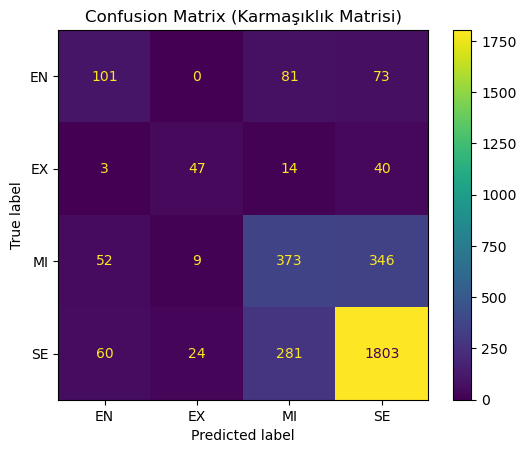

In [137]:


#Matplotlib ile görselleştirme
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.show()



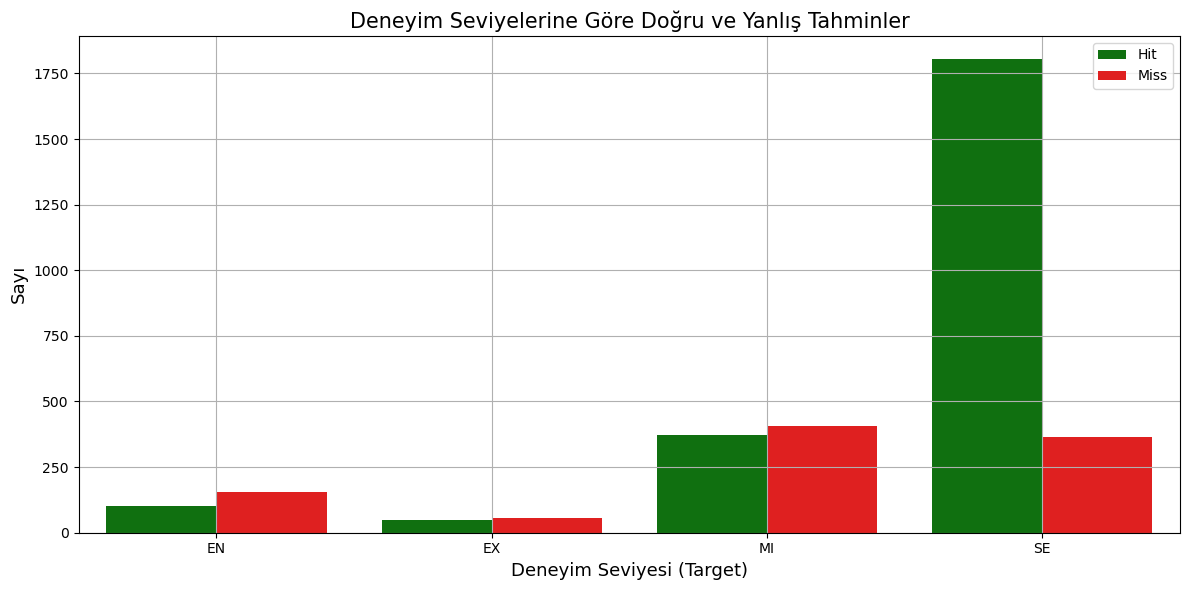

In [138]:
y_pred = model_pipeline.predict(X_test)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

#Hit ve Miss sütunlarını ekleme
comparison_df['Outcome'] = comparison_df.apply(
    lambda row: 'Hit' if row['Actual'] == row['Predicted'] else 'Miss', axis=1
)

#Veriyi Hit/Miss olarak gruplama
plot_data = comparison_df.groupby(['Actual', 'Outcome']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))

#Sütun grafiği oluştur
sns.barplot(
    data=plot_data, 
    x='Actual', 
    y='Count', 
    hue='Outcome', 
    palette={'Hit': 'green', 'Miss': 'red'}
)

plt.title('Deneyim Seviyelerine Göre Doğru ve Yanlış Tahminler', fontsize=15)
plt.xlabel('Deneyim Seviyesi (Target)', fontsize=13)
plt.ylabel('Sayı', fontsize=13)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

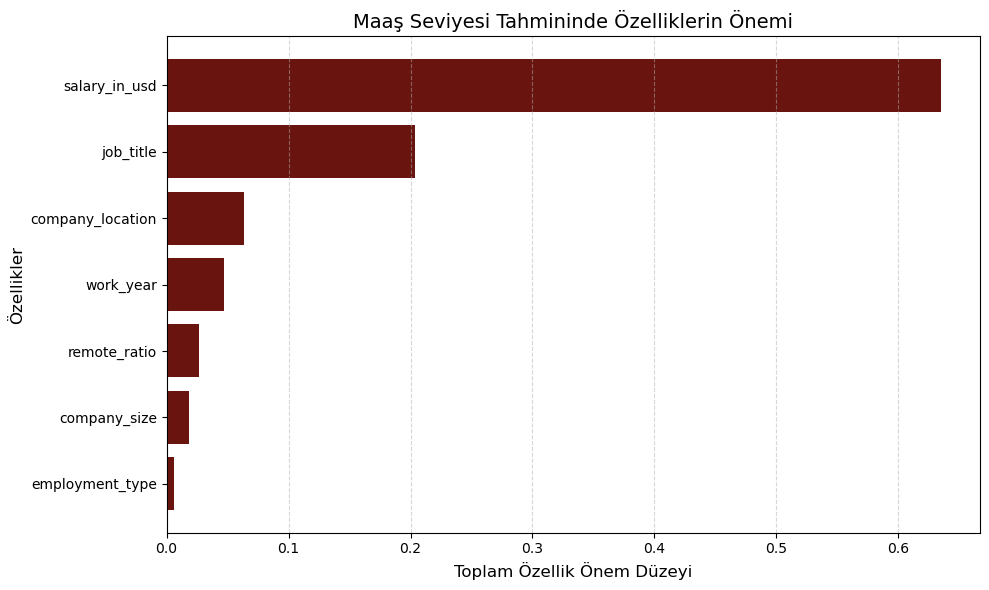

In [139]:
classifier = model_pipeline.named_steps['classifier']
preprocessor = model_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
importances = classifier.feature_importances_
original_features = ['salary_in_usd', 'work_year', 'employment_type', 'job_title', 'remote_ratio', 'company_size', 'company_location']

aggregated_importances = {feature: 0.0 for feature in original_features}

for feature_name, importance in zip(feature_names_out, importances):
    for orig_feature in original_features:
        if orig_feature in feature_name:
            aggregated_importances[orig_feature] += importance
            break

importance_df = pd.DataFrame(list(aggregated_importances.items()), columns=['Özellikler', 'Önem Düzeyi'])
importance_df = importance_df.sort_values(by='Önem Düzeyi', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Özellikler'], importance_df['Önem Düzeyi'], color='#69140E') # Görseldeki maroon/koyu kırmızı tonu

plt.title('Maaş Seviyesi Tahmininde Özelliklerin Önemi', fontsize=14)
plt.xlabel('Toplam Özellik Önem Düzeyi', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## SONUÇ

Bütün işlemeler sonucunda oluşturulan modelimiz %70 başarı oranı ile 'experience_level' sütununu tahmin ediyor. Başarı oranının bu seviyede olmasının sebebi ise görsellerden de anlaşılabileceği gibi veri setimizde 'experience_level' sütunundaki 'EN','EX' ve 'MI' değerlerinin az sayıda bulunmasıdır. Yeterince veri bulunan 'SE' değeri için alınan sonuçların başarı oranı model başarısından daha yüksektir. 'experience_level' sütununu tahmin etmek için en önemli özellik 'salary_in_usd' sütunudur, bu ikisi yüksek oranda korelasyon gösterir. 'employment_type' sütunuyla ise düşük oranda korelasyon gösterir.